# Iris Classification
This notebook gets you hands-on with Seldon Deploy, demonstrating how you can deploy, monitor, manage and explain machine learning models. 

In this notebook you will:

* Explore the Iris dataset
* Train several models on the dataset
* Deploy trained models to Seldon
* Train an anchor tabular explainer and update Seldon deployment with this explainer
* Train an outlier detector (variational autoencoder) and update deployment


For each of the machine learning components (the models themselves, explainer and outlier detector) the workflow is the same: 
1. Train algorithm
2. Push trained artefact to Google Storage bucket
3. Create deployment on Seldon Deploy via API

### Import relevant packages

In [3]:
!pip install seldon-deploy-sdk
!pip install alibi
!pip install alibi-detect
!pip install fsspec
!pip install gcsfs
!pip install dill

     |████████████████████████████████| 675kB 13.9MB/s 
     |████████████████████████████████| 204kB 29.5MB/s 
     |████████████████████████████████| 3.2MB 22.9MB/s 
     |████████████████████████████████| 317kB 14.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 394.3MB 35kB/s 
     |████████████████████████████████| 471kB 10.6MB/s 
     |████████████████████████████████| 3.8MB 32.1MB/s 
     |████████████████████████████████| 2.9MB 33.7MB/s 
     |████████████████████████████████| 28.0MB 144kB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052145 sha256=3c326120e1d2210f7fc18390bb6e124c4e1362a6bf28cc1794c14accbef4989c
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built spacy-lookups-data
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found

In [4]:
from seldon_deploy_sdk import Configuration, ApiClient, SeldonDeploymentsApi, OutlierDetectorApi
from seldon_deploy_sdk.auth import OIDCAuthenticator

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

import numpy as np
import pandas as pd

import xgboost as xgb

from alibi.explainers import AnchorTabular

from alibi_detect.od import Mahalanobis
from alibi_detect.datasets import fetch_kdd
from alibi_detect.utils.data import create_outlier_batch
from alibi_detect.utils.mapping import ord2ohe
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.utils.visualize import plot_instance_score, plot_roc

import dill
import os
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

### Loading the data
Once you have all of the relevant packages you can now explore the dataset. 

In [5]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

X = dataset.data
y = dataset.target

Creating a train/test split of the data to ensure you have an unseen subset of the dataset with which to validate your model's performance. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train[0]

array([4.6, 3.6, 1. , 0.2])

Inspecting a single instance (row) of your data, you can see that it is made up of four different numerical features:
1. Sepal length
2. Sepal width
3. Petal length
4. Petal width

In [8]:
np.unique(y_train)

array([0, 1, 2])

Meanwhile, the labels (your y data) have three separate classes- each representing a different species of Iris:

0. Iris setosa
1. Iris virginica
2. Iris versicolor

I wouldn't worry about remembering those names...

### Model training
Next you will train two separate machine learning models on your dataset. This is representative of the iterative process of algorithm creation which Data Scientists go through during the experimentation process. 

The first model is a logistic regressor which we train using the `.fit()` method, and then evaluate using the `accuracy_score()` function. 

In [9]:
lr = LogisticRegression(max_iter=4000)
lr.fit(X_train, y_train)

print(precision_score(y_test, lr.predict(X_test), average="macro"))
print(recall_score(y_test, lr.predict(X_test), average="macro"))
print(accuracy_score(y_test, lr.predict(X_test)))

1.0
1.0
1.0


You'll notice that your model has perfect evaluation scores, this implies that the model is overfitted on the dataset. For the purposes of this workshop, you're not going to worry about this.

----

You can now train your second machine learning model- an XGBoost classifier. The first step is to convert the dataset into XGBoost's expected DMatrix data format. 

In [10]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Next, you will set the hyperparameters associated with the XGBoost algorithim. This is essentially telling the model how large to be (`max_depth`), how quickly to learn (`eta`), information about the task (`objective`) and  the number of classes (`num_class`). 

Finally, you set the `num_round` which tells XGBoost how many iterations over the dataset to perform. 

In [11]:
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softprob',
    'num_class': 3} 

num_round = 20

You can then train and score the classifier. 

In [12]:
bst = xgb.train(param, dtrain, num_round)
preds = np.asarray([np.argmax(line) for line in bst.predict(dtest)])
print(precision_score(y_test, preds, average="macro"))
print(recall_score(y_test, preds, average="macro"))
print(accuracy_score(y_test, preds))

1.0
1.0
1.0


Again, you can see that the model has overfit on the dataset. However, you will now save both of the models ready for them to be deployed. 

The Scikit-Learn pre-packaged server expects the saved model artefact to be called `model.joblib`. Meanwhile, the XGBoost pre-packaged server expects your model to be called `model.bst` when it is uploaded to our storage bucket.

In [13]:
# Saving the logistic regressor
joblib.dump(lr, 'model.joblib')

# Saving the XGBoost classifier
bst.save_model('model.bst')

### Push model artefacts to GCP

You will now push the saved model binaries to a GCP bucket, where they can be picked up by Seldon and deployed onto Kubernetes. 

You will need to create a unique name for your model artefact. It's easiest to just use your own name. Be careful not to use any upper-case letters or other characters like "_". Dashes are fine, so for example: YOUR_NAME = "john-smith"

In [16]:
YOUR_NAME = "john-smith"

In [17]:
!gsutil cp model.joblib gs://tom-seldon-examples/deploy-workshop/"{YOUR_NAME}"/lr/model.joblib
!gsutil cp model.bst gs://tom-seldon-examples/deploy-workshop/"{YOUR_NAME}"/xgb/model.bst

Copying file://model.joblib [Content-Type=application/octet-stream]...
/ [1 files][   1000 B/   1000 B]                                                
Operation completed over 1 objects/1000.0 B.                                     
Copying file://model.bst [Content-Type=application/octet-stream]...
/ [1 files][ 23.4 KiB/ 23.4 KiB]                                                
Operation completed over 1 objects/23.4 KiB.                                     


### Model Deployment

Deploying the model to a Seldon Deploy trial instance using the `seldon-deploy-sdk`. 

First, setting up the configuration and authentication required to access the cluster. 

In [18]:
SD_IP = "139.59.203.129"

config = Configuration()
config.host = f"http://{SD_IP}/seldon-deploy/api/v1alpha1"
config.oidc_client_id = "sd-api"
config.oidc_server = f"http://{SD_IP}/auth/realms/deploy-realm"

def auth():
    auth = OIDCAuthenticator(config)
    config.access_token = auth.authenticate("admin@seldon.io", "12341234")
    api_client = ApiClient(config)
    return api_client

Now we have configured the IP correctly as well as setup our authentication function we can describe the deployment we would like to create.

You will need to fill in the DEPLOYMENT_NAME, NAMESPACE, and the MODEL_LOCATION, the rest of the deployment description has been templated for you.

We fill first deploy the logistic regression model:

In [19]:
MODEL_NAME = "lr"

DEPLOYMENT_NAME = f"{YOUR_NAME}-{MODEL_NAME}"
MODEL_LOCATION = f"gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/{MODEL_NAME}"

In [20]:
NAMESPACE = "test"
PREPACKAGED_SERVER = "SKLEARN_SERVER"

CPU_REQUESTS = "1"
MEMORY_REQUESTS = "1Gi"

CPU_LIMITS = "1"
MEMORY_LIMITS = "1Gi"

mldeployment = {
    "kind": "SeldonDeployment",
    "metadata": {
        "name": DEPLOYMENT_NAME,
        "namespace": NAMESPACE,
        "labels": {
            "fluentd": "true"
        }
    },
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "spec": {
        "name": DEPLOYMENT_NAME,
        "annotations": {
            "seldon.io/engine-seldon-log-messages-externally": "true"
        },
        "protocol": "seldon",
        "transport": "rest",
        "predictors": [
            {
                "componentSpecs": [
                    {
                        "spec": {
                            "containers": [
                                {
                                    "name": f"{DEPLOYMENT_NAME}-container",
                                    "resources": {
                                        "requests": {
                                            "cpu": CPU_REQUESTS,
                                            "memory": MEMORY_REQUESTS
                                        },
                                        "limits": {
                                            "cpu": CPU_LIMITS,
                                            "memory": MEMORY_LIMITS
                                        }
                                    }
                                }
                            ]
                        }
                    }
                ],
                "name": "default",
                "replicas": 1,
                "traffic": 100,
                "graph": {
                    "implementation": PREPACKAGED_SERVER,
                    "modelUri": MODEL_LOCATION,
                    "name": f"{DEPLOYMENT_NAME}-container",
                    "endpoint": {
                        "type": "REST"
                    },
                    "parameters": [],
                    "children": [],
                    "logger": {
                        "mode": "all"
                    }
                }
            }
        ]
    },
    "status": {}
}

In [21]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'sean-greaves-lr',
              'namespace': 'test',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'sean-greaves-lr',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
        

Our model should now be running as a fully fledged microservice. You can now log into Seldon Deploy and test your deployment:

* URL: http://139.59.203.129/seldon-deploy/
* Username: admin@seldon.io
* Password: 12341234

You can now test your model with this request.
```
{
    "data": {
    "names": ["Sepal length","Sepal width","Petal length", "Petal Width"],
    "ndarray": [
        [6.8,  2.8,  4.8,  1.4]
    ]
    }
}
```

Next, you will add a your XGBoost model as a canary and promote that to be the main predictor. 

In [62]:
MODEL_NAME = "xgb"

DEPLOYMENT_NAME = f"{YOUR_NAME}"
MODEL_LOCATION = f"gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/{MODEL_NAME}"
PREPACKAGED_SERVER = "XGBOOST_SERVER"
canary_spec = 			{
				"componentSpecs": [
					{
						"spec": {
							"containers": [
								{
									"name": "sean-greaves-lr-container",
								}
							]
						},
					}
				],
				"name": "canary",
				"replicas": 1,
				"traffic": 10,
				"shadow": "false",
				"annotations": {
					"seldon.io/canary": "true"
				},
				"graph": {
					"implementation": PREPACKAGED_SERVER,
					"modelUri": MODEL_LOCATION,
					"name": "sean-greaves-lr-container",
					"parameters": [],
					"children": [],
					"logger": {
						"mode": "all"
					}
				}
			}

In [63]:
# insert yaml 
mldeployment['spec']['predictors'] = canary_spec

IndexError: ignored

# Adding a Model Explainer

Next, we shall train an explainer to glean deeper insights into the decisions being made by our model. We will make use of the [Anchors algorithm](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html), which has a production grade implementation available using the Seldon Alibi Explain library.

The algorithm provides model-agnostic (black box) and human interpretable explanations suitable for classification models applied to images, text and tabular data. The idea behind anchors is to explain the behaviour of complex models with high-precision rules called anchors. These anchors are locally sufficient conditions to ensure a certain prediction with a high degree of confidence. Anchor algorithms incorporate coverage, which is the region the explanation applies within and are optimised to maximize coverage.

As an example of anchors for tabular data, if we want to predict whether a person makes less or more than £50,000 per year based on the person’s characteristics including age (continuous variable) and marital status (categorical variable), then the following would be a potential anchor: Hugo makes more than £50,000 because he is married and his age is between 35 and 45 years.

The first step will be to write a simple prediction function which the explainer can call in order to query our logistic regression model.

In [22]:
predict_fn = lambda x: lr.predict(x)

Now, define and fit the AnchorTabular explainer. 

In [23]:
explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_train, disc_perc=(25, 50, 75))

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': None}}
)

Predicting the first instance within the test set, and consequently generating an explanation for that prediction.

In [24]:
idx = 0
print('Prediction: ', class_names[explainer.predictor(X_test[idx].reshape(1, -1))[0]])

explanation = explainer.explain(X_test[idx], threshold=0.95)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction:  versicolor
Anchor: petal width (cm) <= 1.30 AND sepal width (cm) <= 2.80 AND petal length (cm) <= 5.10
Precision: 0.96
Coverage: 0.15


In [25]:
X_test[0]

array([6.1, 2.8, 4.7, 1.2])

Save the explainer. Your explainer must be saved as `explainer.dill` as once again Seldon Deploy will look for this artefact within a top level directory. 

NOTE: Dill is used to serialise the object instead of pickle as it offers a greater flexibilty in the object types which can be serialised. 

In [26]:
dill.dump(explainer, open( "explainer.dill", "wb"))

Uploading the explainer to a Google Storage bucket. 

In [27]:
!gsutil cp explainer.dill gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/lr/explainer.dill

Copying file://explainer.dill [Content-Type=application/octet-stream]...
- [1 files][103.4 MiB/103.4 MiB]                                                
Operation completed over 1 objects/103.4 MiB.                                    


Defining your explainer configuration.

In [28]:
EXPLAINER_TYPE = "AnchorTabular"
EXPLAINER_URI = f"gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/lr"

explainer_spec = {
                    "type": EXPLAINER_TYPE,
                    "modelUri": EXPLAINER_URI,
                    "containerSpec": {
                        "name": "",
                        "resources": {}
                    }
                }

Inserting your explainer configuration into the original `mldeployment`

In [29]:
mldeployment['spec']['predictors'][0]['explainer'] = explainer_spec
mldeployment

{'apiVersion': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'labels': {'fluentd': 'true'},
  'name': 'sean-greaves-lr',
  'namespace': 'test'},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
  'name': 'sean-greaves-lr',
  'predictors': [{'componentSpecs': [{'spec': {'containers': [{'name': 'sean-greaves-lr-container',
         'resources': {'limits': {'cpu': '1', 'memory': '1Gi'},
          'requests': {'cpu': '1', 'memory': '1Gi'}}}]}}],
    'explainer': {'containerSpec': {'name': '', 'resources': {}},
     'modelUri': 'gs://tom-seldon-examples/deploy-workshop/sean-greaves/lr',
     'type': 'AnchorTabular'},
    'graph': {'children': [],
     'endpoint': {'type': 'REST'},
     'implementation': 'SKLEARN_SERVER',
     'logger': {'mode': 'all'},
     'modelUri': 'gs://tom-seldon-examples/deploy-workshop/sean-greaves/lr',
     'name': 'sean-greaves-lr-container',
     'parameters': []},
    'name': 'default',
    

Finally, creating our new deployment with the explainer added. 

In [30]:
deployment_api = SeldonDeploymentsApi(auth())
deployment_api.create_seldon_deployment(namespace=NAMESPACE, mldeployment=mldeployment)

{'api_version': 'machinelearning.seldon.io/v1alpha2',
 'kind': 'SeldonDeployment',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': None,
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'labels': {'fluentd': 'true'},
              'managed_fields': None,
              'name': 'sean-greaves-lr',
              'namespace': 'test',
              'owner_references': None,
              'resource_version': None,
              'self_link': None,
              'uid': None},
 'spec': {'annotations': {'seldon.io/engine-seldon-log-messages-externally': 'true'},
          'name': 'sean-greaves-lr',
          'oauth_key': None,
          'oauth_secret': None,
          'predictors': [{'annotations': None,
                          'component_specs': [{'hpa_spec': None,
        

# Outlier Detection

In this example you will make use of a Mahalanbois outlier detector. This algorithm calculates an outlier score, which is a measure of distance from the center of the features distribution (Mahalanobis distance). The Mahalanobis distance is focused on the idea of measuring how many standard deviations away your data point is from the mean of the distribution. 

The Mahalanobis outlier detector is an online detector, meaning that it has a running mean and covariance matrix with which it compares the new data points with to classify as outliers or not. It is online in the sense that each new data point contributes to this running mean and covariance matrix.

The first step is to initialise your outlier detector. There are 4 parameters which will be critical to the performance of your outlier detector: 
* `threshold`: The distance threshold above which your data instance is flagged as an outlier. To begin with you can leave this blank and infer a given threshold later when fitting your detector to the dataset. 
* `n_components`: The number of components to use within the PCA. PCA is used to reduce the number of feature dimensions. This will make it easier to compute the Mahalanbois calculation especially on high feature datasets. 
* `std_clip`: Feature-wise standard deviation used to clip the observations before updating the mean and covariance matrix. 
* `start_clip`: Number of observations before clipping is applied.

If your data has categorical features then these can be specified using the `cat_vars` parameter. 

Firstly, you will set the `n_components` value. The simplest way to set this value is using `n_components == min(n_samples, n_features)` and then scaling down if computational performance slows the computation of outliers.

A more rigourous approach is demonstrated below. This essentially calculates the covariance matrix- how each feature varies with every other feature. This determines the eigenvalues and eigenvectors of the covariance matrix. 

The eigenvalues capture the variance of each component in the direction of the eigenvector. Therefore, you can use this to understand the contribution of each feature to the overall variance. From here you can make a determination of how many components to include in your PCA, as you now understand the contribution of each of the features. 

In [31]:
mean, stdev = X_train.mean(axis=0), X_train.std(axis=0)
cov_mat = np.cov((X_train - mean).T)
cov_mat

array([[ 0.67865476, -0.03956162,  1.24462745,  0.49670868],
       [-0.03956162,  0.20171148, -0.34006162, -0.12484594],
       [ 1.24462745, -0.34006162,  3.07071148,  1.26893557],
       [ 0.49670868, -0.12484594,  1.26893557,  0.56593838]])

In [32]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print(f'Eigenvectors \n {eig_vecs}')
print(f'Eigenvectors \n {eig_vals}')

Eigenvectors 
 [[ 0.35922175 -0.66072216 -0.5781132   0.31652976]
 [-0.08867716 -0.72708635  0.60569412 -0.31083185]
 [ 0.85800365  0.16688652  0.08006791 -0.4791323 ]
 [ 0.35626652  0.08331002  0.54084091  0.75738016]]
Eigenvectors 
 [4.15384465 0.25811933 0.08303984 0.02201228]


In [33]:
total = sum(eig_vals)
var_exp = [(i / total)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print("Variance captured by each component:")
print(var_exp)
print(80 * "-")
print("Cumulative variance captured as we travel each component:")
print(cum_var_exp)

Variance captured by each component:
[91.95992565966301, 5.714377120220816, 1.8383782587915891, 0.48731896132459807]
--------------------------------------------------------------------------------
Cumulative variance captured as we travel each component:
[ 91.95992566  97.67430278  99.51268104 100.        ]


From the above you can see that 91.9% of the variance is captured by a single component, therefore you could reasonably set `n_components = 1`. However, you gain an additional 5% points by including a second one, and therefore:

In [34]:
n_components = 2

`std_clip` is used to ensure that outliers do not impact the typical operation of the detector. If many, many outliers (e.g. in a DDoS attack, or multiple broken parts in a assembly line) were sent to the detector then the weights (covariance matrix) would shift to include these outliers, therefore we set a `std_clip` whereby any data points above this clip level will have their `stdev` clipped to this maximal value. 

Setting the `std_clip` is case by case dependent, but you will use the following heuristic to set it. You will look at the `stdev` across the features, selecting the one which is the most widely distributed (the highest value). You will then set the `std_clip` to be 2 stdevs away from this maximal value. 

The code snippet below illustrates this.

In [35]:
std_clip = (2 * stdev.max(axis=0)).round(decimals=2)
std_clip

3.49

Finally, the `start_clip` value is used to "warm up" the outlier detector. When the detector is first initialised it can be sensitive to new observations- which lead to large changes in the online mean and covariance matrix. During this period of time you do not want to show the outlier detector any outliers as it can greatly skew the accuracy of the running mean and covariance matrix.

Thus during this "warm up" period you only show the outlier detector examples of normal data, and do not perform any clipping. The `start_clip` value determines after which point you should begin clipping data points and introducing outliers into the mix. 

Therefore `start_clip` in this case will be equal to the length of `X_train`, as you know that there are no outlying data points within the original Iris dataset. 

In [36]:
start_clip = len(X_train)
start_clip

120

In [37]:
threshold = None

od = Mahalanobis(threshold,
                 n_components=n_components,
                 std_clip=std_clip,
                 start_clip=start_clip)

No threshold level set. Need to infer threshold using `infer_threshold`.


If you were dealing with categorical variables you would now run `od.fit(...)` however because the Iris dataset is solely continuous variables you do not need to perform this step. 

------

You do however now need to set the threshold of Mahalanobis distance above which you consider a data instance an outlier. This can be done using the convenient `infer_threshold()` method. 

You first create a synthetic outlier batch using your training data and labels, with a certain percentage of the batch as outliers. Based upon this percentage of outliers you shall update the threshold value.

In [38]:
np.random.seed(0)
perc_outlier = 5

threshold_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=perc_outlier)
X_threshold, y_threshold = threshold_batch.data.astype('float'), threshold_batch.target
X_threshold = (X_threshold - mean) / stdev
print('{}% outliers'.format(100 * y_threshold.mean()))

5.0% outliers


Once you have created the synthetic data we can determine the threshold using `infer_threshold`:

In [39]:
od.infer_threshold(X_threshold, threshold_perc=100-perc_outlier)
print('New threshold: {}'.format(od.threshold))
threshold = od.threshold

New threshold: 8.10689543287148


You can now test your threshold by generating a second batch of outlying data, this time with a higher proportion of outliers: 

In [40]:
np.random.seed(1)
outlier_batch = create_outlier_batch(X_train, y_train, n_samples=1000, perc_outlier=10)
X_outlier, y_outlier = outlier_batch.data.astype('float'), outlier_batch.target
X_outlier = (X_outlier - mean) / stdev
print(X_outlier.shape, y_outlier.shape)
print('{}% outliers'.format(100 * y_outlier.mean()))

(1000, 4) (1000,)
10.0% outliers


Generating outlier predictions from your new detector using the freshly created outlier batch:

In [42]:
od_preds = od.predict(X_outlier, return_instance_score=True)

F1 score: 0.9304812834224598


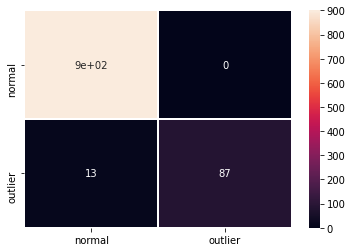

In [43]:
labels = outlier_batch.target_names
y_pred = od_preds['data']['is_outlier']
f1 = f1_score(y_outlier, y_pred)
print('F1 score: {}'.format(f1))
cm = confusion_matrix(y_outlier, y_pred)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
sns.heatmap(df_cm, annot=True, cbar=True, linewidths=.5)
plt.show()

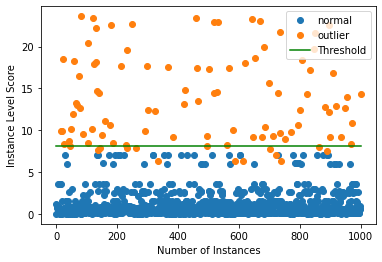

In [44]:
plot_instance_score(od_preds, y_outlier, labels, od.threshold)

Saving your handiwork is simple. 

In [45]:
save_detector(od, "outlier_detector")

Directory outlier_detector does not exist and is now created.


Uploading the outlier detector to a Google Storage bucket.

Make sure to replace `<YOUR NAME>` with your name to prevent overwriting others artefacts.

In [47]:
# Recursive copy this time as the OD is saved as a directory containing all the relevant binaries and parameters.
!gsutil cp -r outlier_detector gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/lr/

Copying file://outlier_detector/Mahalanobis.pickle [Content-Type=application/octet-stream]...
Copying file://outlier_detector/meta.pickle [Content-Type=application/octet-stream]...
/ [2 files][  838.0 B/  838.0 B]                                                
Operation completed over 2 objects/838.0 B.                                      


In [52]:
OD_URI = f'gs://tom-seldon-examples/deploy-workshop/{YOUR_NAME}/lr/outlier_detector/'
OD_NAME = 'mahalobanis-od'

od_config = {'deployment': DEPLOYMENT_NAME,
             'deployment_namespace': NAMESPACE,
             'namespace': 'seldon-logs',
             'params': {'drift_batch_size': None,
                        'env_secret_ref': None,
                        'event_source': f'io.seldon.serving.dev-seldondeployment-{DEPLOYMENT_NAME}-outlier',
                        'event_type': 'io.seldon.serving.inference.outlier',
                        'http_port': '8080',
                        'model_name': OD_NAME,
                        'protocol': 'seldon.http',
                        'reply_url': 'http://seldon-request-logger.seldon-logs',
                        'storage_uri': OD_URI,
                        'user_permission': None},
             'prom_scraping': None,
             'url': None}

In [53]:
od_api = OutlierDetectorApi(auth())
od_api.create_outlier_detector_seldon_deployment(name=DEPLOYMENT_NAME,
                                                 namespace=NAMESPACE,
                                                 outlier_detector=od_config)

{'deployment': 'sean-greaves-lr',
 'deployment_namespace': None,
 'namespace': 'seldon-logs',
 'params': {'drift_batch_size': None,
            'env_secret_ref': None,
            'event_source': 'io.seldon.serving.test-seldondeployment-sean-greaves-lr-outlier',
            'event_type': 'io.seldon.serving.inference.outlier',
            'http_port': '8080',
            'model_name': 'mahalobanis-od',
            'protocol': 'seldon.http',
            'reply_url': 'http://seldon-request-logger.seldon-logs',
            'storage_uri': 'gs://tom-seldon-examples/deploy-workshop/sean-greaves/lr/outlier_detector/',
            'user_permission': None},
 'prom_scraping': None,
 'url': None}